In [1]:
import pandas as pd
from zipfile import ZipFile
import os, random, warnings
import cv2#, pydicom
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import get_custom_objects
#warnings.filterwarnings('ignore')
import skimage.measure as measure
import scipy.ndimage
import lib.Seg_func_lib as func

Tensorflow version : 2.5.0
default folder: /home/dfeng/project/IPFimage/train/


## Image Segmentation Notebook 
This notebook is designed for segmentation of CT images

In [2]:
folder = '/home/dfeng/project/IPFimage/train/'#change this to the folder with ct scan

In [3]:
patients  = os.listdir(folder)
print(patients[:5])

['ID00007637202177411956430', 'ID00009637202177434476278', 'ID00010637202177584971671', 'ID00011637202177653955184', 'ID00012637202177665765362']


In [4]:
try:
    if not model:
        model = func.get_segmentation_model()
except:
    model = func.get_segmentation_model()
    

Load segmentation model...


## Unet segmented model summary:

In [5]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 128, 32) 864         Input[0][0]                      
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 128, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 128, 32) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [6]:
pid=patients[0]
input_img = func.Load_pateint_ct_scan_HU(pid)
num = 15

Text(0.5, 1.0, 'original')

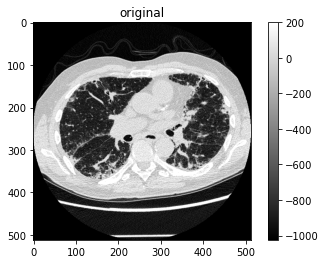

In [7]:
plt.imshow(np.array(input_img[num]), cmap='gray')
plt.colorbar()
plt.title('original')

In [8]:
input = func.Load_pateint_ct_scan_nf(pid)

In [9]:
pred_masks = model.predict(input, verbose=0)
pred_masks = (pred_masks>0.5).astype(np.float32)

Text(0.5, 1.0, 'mask')

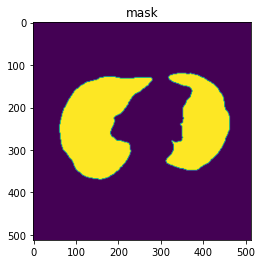

In [10]:
DIM = 512
pre_res = cv2.resize(pred_masks[num], (DIM,DIM), cv2.INTER_AREA)
plt.imshow(pre_res)
plt.title('mask')

Text(0.5, 1.0, 'segmented lung')

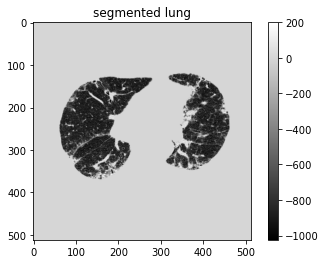

In [11]:
plt.imshow(np.array(input_img[num]*pre_res), cmap='gray')
plt.colorbar()
plt.title('segmented lung')

## Create segmentated images' input directionary
Using dictory is very fast (O(1)), however, this might take a while to run and might consume a lot of memory for a large dataset.

In [ ]:
CT_img = {}
DIM = 512
for ind, pid in enumerate(patients):
    try:
        input=Load_pateint_ct_scan_nf(pid)
        imgs = Load_pateint_ct_scan_HU(pid)
        pred_masks = model.predict(input, verbose=0)
        pred_masks = (pred_masks>0.5).astype(np.float32)
        
        f_imgs = []
        for idx, (image, mask) in enumerate(zip(imgs, pred_masks)):
            pre_res = cv2.resize(mask, (DIM,DIM), cv2.INTER_AREA)
            lungimg = pre_res*image
            if sum(sum(abs(lungimg)))>1:
                f_imgs += [lungimg]
        CT_img[pid] = np.array(f_imgs)
        
        print(ind, pid)
        
    except:
        print('cant process', pid)
        

In [ ]:
# uncomment below to save
#np.save('../pre-data/CT_img_tr-200-1000-HU-512-o', CT_img)